In [38]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

In [5]:
training_data = datasets.FashionMNIST(root="data",train=True,download=True,transform=ToTensor())
testing_data = datasets.FashionMNIST(root="data",train=False,download=True,transform=ToTensor())

In [6]:
batch_size = 64

training_data_loader = DataLoader(training_data,batch_size=batch_size)
testing_data_loader = DataLoader(testing_data,batch_size=batch_size)

for X,y in testing_data_loader:
    print(f"Shape of X[N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X[N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [7]:
device = ('cuda' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"using device {device}")

using device cpu


In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28,512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [9]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [25]:
def train(dataloader, model:nn.Module, loss_fn:nn.CrossEntropyLoss, optimizer):
    size = len(dataloader.dataset)
    model.train() # sets module in training mode
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)

        #predict and get the error
        pred = model(X)
        loss = loss_fn(pred,y)

        #backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch+1)*len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [26]:
def test(dataloader, model:nn.Module, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # sets module in evaluation mode
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [27]:
epochs = 5
for t in range(epochs):
    
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_data_loader, model, loss_fn, optimizer)
    test(testing_data_loader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 2.299724  [   64/60000]
loss: 2.291102  [ 6464/60000]
loss: 2.274094  [12864/60000]
loss: 2.266974  [19264/60000]
loss: 2.249399  [25664/60000]
loss: 2.226276  [32064/60000]
loss: 2.227283  [38464/60000]
loss: 2.192272  [44864/60000]
loss: 2.183540  [51264/60000]
loss: 2.154141  [57664/60000]
Test Error: 
 Accuracy: 47.2%, Avg loss: 2.157632 

Epoch 2
-------------------------------
loss: 2.164852  [   64/60000]
loss: 2.162076  [ 6464/60000]
loss: 2.105527  [12864/60000]
loss: 2.117648  [19264/60000]
loss: 2.067086  [25664/60000]
loss: 2.004032  [32064/60000]
loss: 2.031563  [38464/60000]
loss: 1.949140  [44864/60000]
loss: 1.950905  [51264/60000]
loss: 1.876613  [57664/60000]
Test Error: 
 Accuracy: 53.1%, Avg loss: 1.888081 

Epoch 3
-------------------------------
loss: 1.919366  [   64/60000]
loss: 1.898294  [ 6464/60000]
loss: 1.781851  [12864/60000]
loss: 1.815315  [19264/60000]
loss: 1.703098  [25664/60000]
loss: 1.652561  [32064/600

In [29]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [10]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [12]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x,y = testing_data[0][0], testing_data[0][1]
with torch.no_grad():
    pred = model(x)
    print(pred)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')


tensor([[-2.4318, -2.6873, -1.1547, -2.0186, -1.0958,  2.2845, -1.1788,  2.5103,
          1.6418,  3.0134]])
Predicted: "Ankle boot", Actual: "Ankle boot"


### Tensors
Are similar to numpy ndarrays only these can be run on a GPU.

In [3]:
import numpy as np

In [4]:
data = [[1,2],[3,4]]
data_tensor = torch.tensor(data)
print(data_tensor)
print(type(data_tensor))
np_ndarray = np.array(data)
data_tensor = torch.from_numpy(np_ndarray)
print(data_tensor)
print(type(data_tensor))
x_ones = torch.ones_like(data_tensor)
print(f"Ones Tensor: \n {x_ones} \n")
x_rand = torch.rand_like(data_tensor, dtype=torch.float64)
print(f"Random Tensor: \n {x_rand} \n")
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

tensor([[1, 2],
        [3, 4]])
<class 'torch.Tensor'>
tensor([[1, 2],
        [3, 4]])
<class 'torch.Tensor'>
Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.6572, 0.5243],
        [0.8393, 0.3537]], dtype=torch.float64) 

Random Tensor: 
 tensor([[0.6256, 0.8364, 0.5874],
        [0.9177, 0.1581, 0.5875]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [5]:
tensor = torch.rand((3,4),dtype=torch.float64)
print(tensor)
print(f"shape is {tensor.shape}")
print(f"datatype is {tensor.dtype}")
print(f"device is {tensor.device}")


tensor([[0.7562, 0.1546, 0.7825, 0.6120],
        [0.5661, 0.1221, 0.5718, 0.7756],
        [0.2494, 0.9050, 0.3983, 0.1894]], dtype=torch.float64)
shape is torch.Size([3, 4])
datatype is torch.float64
device is cpu


In [20]:
# We move our tensor to the GPU if available
if torch.cuda.is_available():
    tensor = tensor.to("cuda")
tensor = torch.rand(3,4)
# print(tensor)
first_row = tensor[0]
# print(first_row)
first_row = tensor[0,:]
# print(first_row)
first_column = tensor[:,0]
# print(first_column)
last_column = tensor[:,-1]
# print(last_column)
last_column = tensor[...,-1]
# print(last_column)
t1 = torch.cat([tensor, tensor], dim=1)
# print(t1)
t2 = torch.cat([tensor, tensor], dim=0)
# print(t2)

# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
# ``tensor.T`` returns the transpose of a tensor
y1 = tensor @ tensor.T
# print(y1)
y2 = tensor.matmul(tensor.T)
# print(y2)

y3 = torch.rand_like(y1)
# print(y3)

y3_mult = torch.matmul(tensor, tensor.T, out=y3)
# print(y3_mult)


# # This computes the element-wise product. z1, z2, z3 will have the same value
z1 = tensor * tensor
# print(z1)
z2 = tensor.mul(tensor)
# print(z2)

z3 = torch.rand_like(tensor)
# print(z3)
# torch.mul(tensor, tensor, out=z3)

agg = tensor.sum()
agg_item = agg.item()
# print(agg_item, type(agg_item))
# print(f"{tensor} \n")
tensor.add_(5)
# print(tensor)

t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")
t.add_(4)
print(f"t: {t}")
print(f"n: {n}")
n = np.ones(5)
t = torch.from_numpy(n)
np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]
t: tensor([5., 5., 5., 5., 5.])
n: [5. 5. 5. 5. 5.]
t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
n: [2. 2. 2. 2. 2.]


### DATASETS & DATALOADERS

In [48]:
import pandas as pd
from PIL import Image
import uuid

labels_map = {
    0: "TShirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "AnkleBoot",
}

train_data = pd.read_csv("data/FashionMNIST2/archive/fashion-mnist_test.csv")
train_data = train_data.to_numpy()
labels_dataset = []
for data in train_data:
    label = data[0].item()
    image_file_name = labels_map[label]+str(uuid.uuid4())+".jpg"
    image_path = "data/FashionMNIST2/test/images/"+image_file_name
    image_data = data[1:].reshape((28,28))
    img = Image.fromarray(np.asarray(image_data).astype(np.uint8))
    img.save(image_path)
    labels_dataset.append([image_file_name,label])

labels = pd.DataFrame(labels_dataset)
labels.to_csv("data/FashionMNIST2/test/labels.csv",index=False,header=False)

In [25]:

from torch.utils.data import Dataset,DataLoader
from torchvision.io import read_image
import pandas as pd
import os

class CustomImageDataset(Dataset):
    def __init__(self, images_directory, targets_file, image_transform=None, label_tranform=None):
        self.images_directory = images_directory
        self.image_labels = pd.read_csv(targets_file)
        self.image_transform = image_transform
        self.label_tranform = label_tranform
    
    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, index):
        image_path = os.path.join(self.images_directory,self.image_labels.iloc[index, 0])
        image = read_image(image_path)
        label = self.image_labels.iloc[index, 1]
        if self.image_transform:
            image = self.image_transform(image)
        if self.label_tranform:
            label = self.label_tranform(label)
        return image, label
    

In [26]:
train_dataset = CustomImageDataset("data/FashionMNIST2/train/images/","data/FashionMNIST2/train/labels.csv")
test_dataset = CustomImageDataset("data/FashionMNIST2/test/images/","data/FashionMNIST2/test/labels.csv")

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
torch.Size([1, 28, 28])


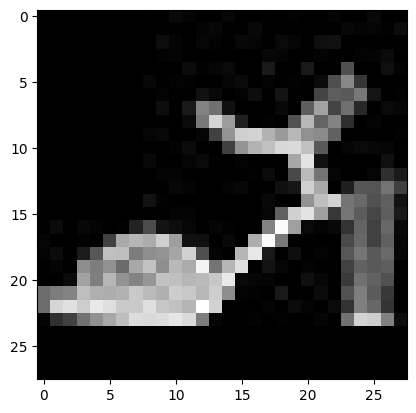

Label: 5


In [29]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(train_features[0].shape)
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [39]:
train_dataset = CustomImageDataset("data/FashionMNIST2/train/images/",
                                   "data/FashionMNIST2/train/labels.csv",
                                   image_transform=ToTensor(),
                                   label_tranform=Lambda(lambda y:torch.zeros(10,dtype=torch.float64).scatter_(0, torch.tensor(6), value=1))
                                )
test_dataset = CustomImageDataset("data/FashionMNIST2/test/images/",
                                    "data/FashionMNIST2/test/labels.csv",
                                    image_transform=ToTensor(),
                                    label_tranform=Lambda(lambda y:torch.zeros(10,dtype=torch.float64).scatter_(0, torch.tensor(6), value=1))
                                 )

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)